In [1]:
import tensorflow as tf
from IPython.display import clear_output
import itertools, re, os, random, keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pylab import rcParams
from keras.models import Sequential, save_model

from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Input, concatenate, Reshape, Conv2DTranspose, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import layers, Input, Model, models, regularizers, optimizers

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from sklearn.utils import class_weight
import tensorflow_addons as tfa

from keras.layers.convolutional import Conv1D, Convolution1D, MaxPooling1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
from keras.utils.vis_utils import plot_model

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
from tensorflow.keras import initializers
import gc
tf.config.run_functions_eagerly(True)
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
import pprint

In [2]:
from __future__ import division
from collections import Sequence

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

**masks**

In [4]:
use=[*range(0, 1250, 1)]

In [5]:
num=np.load('../input/use-this-bro/goodboy.npy', allow_pickle=True)
x, y,  = num.T
n=np.stack(np.array(y))
df=pd.DataFrame(n)
df['image_path']=x

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,image_path
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/hatworkers/Self Driving Car.v3-fixed-...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/hatworkers/Self Driving Car.v3-fixed-...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/hatworkers/Self Driving Car.v3-fixed-...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/hatworkers/Self Driving Car.v3-fixed-...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/hatworkers/Self Driving Car.v3-fixed-...


In [7]:
tfrecords_dir = "tfrecords"
num_samples = 2980
num_tfrecords = len(df) // num_samples
if len(df) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  

In [8]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, example):
    feature = {
        "image": image_feature(image),
        "label": float_feature_list(example)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.VarLenFeature(tf.float32)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["label"] = tf.sparse.to_dense(example["label"])
    return example

In [9]:
def devil(xt):
    samples = df.iloc[(xt * num_samples) : ((xt + 1) * num_samples)]
    samples = samples.reset_index(drop=True)
    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (xt, len(samples))
    ) as writer:
        for sample in range(len(samples)):
            image_path = samples.loc[sample]['image_path']
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            sample = samples.loc[sample][use]
            example = create_example(image, sample)
            writer.write(example.SerializeToString())
    return 1        

In [10]:
from multiprocessing import Pool
pool = Pool()
jobs=[]
jobs.append(pool.apply_async(devil,[0]))
jobs.append(pool.apply_async(devil,[1]))
jobs.append(pool.apply_async(devil,[2]))
jobs.append(pool.apply_async(devil,[3]))
jobs.append(pool.apply_async(devil,[4]))
jobs.append(pool.apply_async(devil,[5]))
jobs.append(pool.apply_async(devil,[6]))
jobs.append(pool.apply_async(devil,[7]))
jobs.append(pool.apply_async(devil,[8]))
jobs.append(pool.apply_async(devil,[9]))
stu = jobs[0].get()+jobs[1].get()+jobs[2].get()+jobs[3].get()+jobs[4].get()+jobs[5].get()+jobs[6].get()+jobs[7].get()+jobs[8].get()+jobs[9].get()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

label: [0. 0. 0. ... 0. 0. 0.]
Image shape: (512, 512, 3)


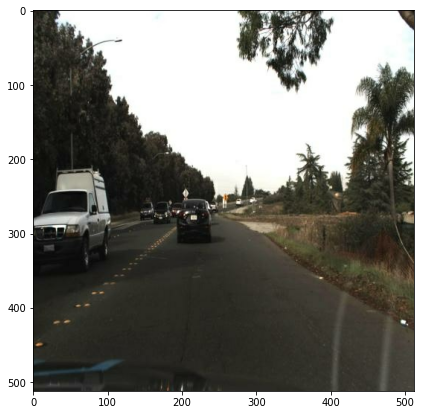

In [11]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()